Starting grid search for Linear Regression...
Best parameters for Linear Regression: {'fit_intercept': True}
Best cross-validation score (MSE): 0.09452543863444898
Starting grid search for SVM...
Best parameters for SVM: {'C': 0.1, 'kernel': 'rbf'}
Best cross-validation score (MSE): 0.08299804895561125
Starting grid search for Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Best cross-validation score (MSE): 0.08069240506329114
Starting grid search for KNN...
Best parameters for KNN: {'n_neighbors': 7, 'weights': 'uniform'}
Best cross-validation score (MSE): 0.08716094032549729
Starting grid search for ANN...
Best parameters for ANN: {'activation': 'tanh', 'hidden_layer_sizes': (100,)}
Best cross-validation score (MSE): 0.0772944215595536
Starting grid search for XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 50}
Best cross-validation score (MSE): 0.08288008964254986


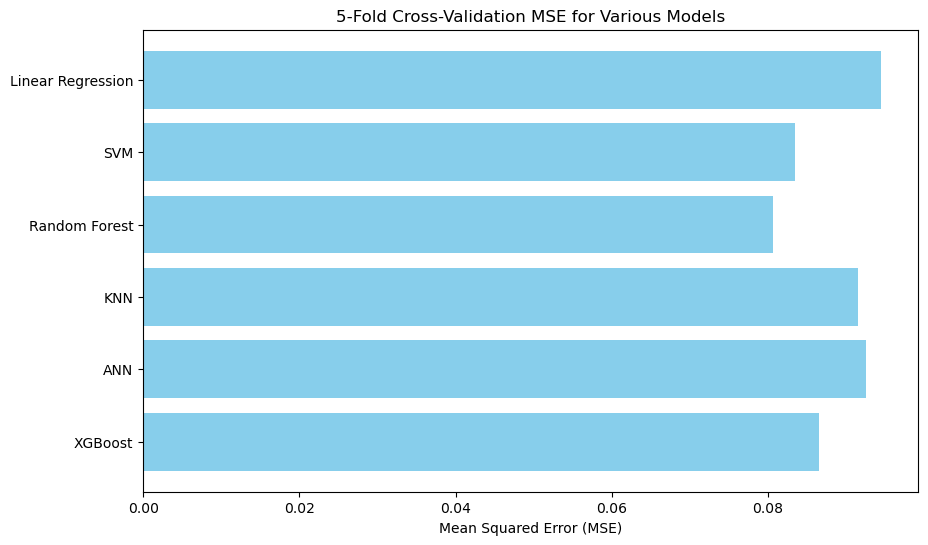

Linear Regression:
  Runtime: 0.001210 seconds
  Training MSE: 0.088669

SVM:
  Runtime: 0.007971 seconds
  Training MSE: 0.037739

Random Forest:
  Runtime: 0.122113 seconds
  Training MSE: 0.011462

KNN:
  Runtime: 0.000682 seconds
  Training MSE: 0.060051

ANN:
  Runtime: 0.121514 seconds
  Training MSE: 0.049742

XGBoost:
  Runtime: 0.095734 seconds
  Training MSE: 0.013590



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import time

file_path = '/Users/victoriali/Desktop/student-mat.csv'

data = pd.read_csv(file_path, delimiter=';')

# Select numerical data for PCA
numerical_data = data.select_dtypes(include=[float, int])

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Apply PCA to reduce the number of features to half
pca = PCA(n_components=int(numerical_data.shape[1] / 2))
principal_components = pca.fit_transform(scaled_data)

# Assume 'G3' as the target variable and convert it into a binary classification problem
data['Passed'] = (data['G3'] >= 10).astype(int)

# Combine the principal components with the binary target
pca_data = pd.DataFrame(principal_components)
pca_data['Passed'] = data['Passed']

# Split the dataset into features and target variable
X = pca_data.drop('Passed', axis=1)
y = pca_data['Passed']

# Define models for cross-validation
models = {
    'Linear Regression': LinearRegression(),
    'SVM': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'ANN': MLPRegressor(max_iter=1000, random_state=42),
    'XGBoost': GradientBoostingRegressor(random_state=42)
}

# Define hyperparameter grids for each model
param_grid_lr = {'fit_intercept': [True, False]}
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
param_grid_ann = {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['tanh', 'relu']}
param_grid_xgb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2]}

# Perform grid search for each model
best_models = {}
for model_name, model, param_grid in zip(
    ['Linear Regression', 'SVM', 'Random Forest', 'KNN', 'ANN', 'XGBoost'],
    [LinearRegression(), SVR(), RandomForestRegressor(random_state=42), KNeighborsRegressor(),
     MLPRegressor(max_iter=1000, random_state=42), GradientBoostingRegressor(random_state=42)],
    [param_grid_lr, param_grid_svm, param_grid_rf, param_grid_knn, param_grid_ann, param_grid_xgb]
):
    print(f"Starting grid search for {model_name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score (MSE): {-grid_search.best_score_}")

# Perform 5-fold cross-validation and compute MSE for each model
cv_mse = {name: cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean() for name, model in models.items()}

# Convert negative MSE to positive for visualization
positive_mse = {model: -mse for model, mse in cv_mse.items()}

# Prepare data for bar chart
model_names = list(positive_mse.keys())
scores_values = list(positive_mse.values())

# Create a horizontal bar chart for visualization
plt.figure(figsize=(10, 6))
plt.barh(model_names, scores_values, color='skyblue')
plt.xlabel('Mean Squared Error (MSE)')
plt.title('5-Fold Cross-Validation MSE for Various Models')
plt.gca().invert_yaxis()
plt.show()

# Train models and evaluate performance
performance_and_runtime = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X, y)
    end_time = time.time()
    runtime = end_time - start_time
    training_mse = mean_squared_error(y, model.predict(X))
    
    performance_and_runtime[name] = {
        'Runtime (s)': runtime,
        'Training MSE': training_mse
    }

# Display the runtime and training MSE for each model
for model_name, metrics in performance_and_runtime.items():
    print(f"{model_name}:")
    print(f"  Runtime: {metrics['Runtime (s)']:.6f} seconds")
    print(f"  Training MSE: {metrics['Training MSE']:.6f}\n")

